# PyTorch and bag-of-words

Thinking that position of words might matter, this is my attempt at solving this problem using 2-grams.

## Set up environment

### Download dataset manually

Let's start downloading the train dataset from Kaggle's website:

https://www.kaggle.com/c/nlp-getting-started/data

I downloaded the dataset manually and saved if in the 'input' folder.

The dataset could be downloaded programmatically using Kaggle API, but it requires authentication and it would be unsafe on a notebook that is meant to be shared.

### Read dataset from CSV

Read the dataset from the CSV file.

In [1]:
import numpy as np
import pandas as pd

# Read train dataset
train_df = pd.read_csv('input/train.csv', encoding = 'ISO-8859-1', index_col='id')
train_labels = train_df.pop('target').tolist()

# Read test dataset
test_df = pd.read_csv('input/test.csv', encoding = 'ISO-8859-1', index_col='id')

# Check
train_df.head()

,keyword,location,text
id,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...
4,NaN,NaN,Forest fire near La Ronge Sask. Canada
5,NaN,NaN,All residents asked to 'shelter in place' are ...
6,NaN,NaN,"13,000 people receive #wildfires evacuation or..."
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...


## Text tokenization

Tweets are tokenized in a multi-step process:
1. **Remove hyperlinks:** Replace hyperlinks with the keyword “islink”.
1. **Numbers:** Replace all numbers with the keyword “isnumber”.
1. **Punctuation:** Remove any non-alphanumeric character.
1. **Case:** Make all tweets lowercase.
1. **Split** text into different words.
1. **Remove stopwords**.
1. **Stem words**.

I use the _Natural Language Toolkit_ and _Regular Expressions_ to tokenize tweets.

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
import re

def tweet_to_2grams(text):
    nltk.download('stopwords', quiet=True)
    stemmer = PorterStemmer()

    text = re.sub(r'http\S+', ' islink ', text) # replace hyperlinks with keyword
    text = re.sub(r'(?!,$)[\d,.]+', ' isnumber ', text) # replace numbers with keyword
    text = re.sub(r'[^a-zA-Z0-0]', ' ', text.lower()) # Remove non-alphanumeric characters and convert to lower case
    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
    words = [PorterStemmer().stem(w) for w in words] # stem
    
    # Pair words with their previous one (except "islink" keyword)
    if(len(words) > 1):
        ngrams = []
        prev_word = words[0]
        for word in words[1:]:
            if(word != 'islink'):
                ngrams.append(prev_word + ' ' + word)
                prev_word = word
            else:
                ngrams.append(word)
        words = ngrams
        
    return words

In [5]:
# Train dataset
words = []
for index, row in train_df.iterrows():
    words.append(tweet_to_2grams(row['text']))

train_df['words'] = words

# Test dataset
words = []
for index, row in test_df.iterrows():
    words.append(tweet_to_2grams(row['text']))

test_df['words'] = words

words = [] # Free words

train_df.head() # Check

,keyword,location,text,words
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,"[deed reason, reason earthquak, earthquak may,..."
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,"[forest fire, fire near, near la, la rong, ron..."
5,NaN,NaN,All residents asked to 'shelter in place' are ...,"[resid ask, ask shelter, shelter place, place ..."
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...","[isnumb peopl, peopl receiv, receiv wildfir, w..."
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,"[got sent, sent photo, photo rubi, rubi alaska..."


## Build vocabulary

Create a vocabulary using the tokens found in the train dataset

In [6]:
# Create word dictionary
def build_vocabulary(data, vocabulary_size = 5000):
    """Construct and return a dictionary mapping each of the most frequently appearing words to a unique integer."""
    
    # TODO: Determine how often each word appears in `data`. Note that `data` is a list of sentences and that a
    #       sentence is a list of words.
    
    word_count = {} # A dict storing the words that appear in the reviews along with how often they occur
    for sentence in data:
        for word in sentence:
            if word in word_count:
                word_count[word] += 1
            else:
                word_count[word] = 1
                
    # TODO: Sort the words found in `data` so that sorted_words[0] is the most frequently appearing word and
    #       sorted_words[-1] is the least frequently appearing word.
    
    import operator
    
    sorted_words = None
    sorted_words = [item[0] for item in sorted(word_count.items(), key=lambda x: x[1], reverse=True)]
        
    word_dict = {} # This is what we are building, a dictionary that translates words into integers
    for idx, word in enumerate(sorted_words[:vocabulary_size - 2]): # The -2 is so that we save room for the 'no word'
        word_dict[word] = idx + 2                              # 'infrequent' labels
        
    return word_dict, word_count

In [7]:
# Build dictionary
vocabulary_size = 3000
word_vocabulary, word_count = build_vocabulary(train_df['words'], vocabulary_size=vocabulary_size)

# dict size
print("Vocabulary size:", len(word_vocabulary))

# Ten most frequently appearing words in the training set.
n = 0
for word in word_vocabulary:
    print(word_count[word], word)
    if n > 10:
        break
    n += 1

Vocabulary size: 2998
4663 islink
863 isnumb isnumb
95 isnumb year
80 bodi bag
73 isnumb pm
73 mh isnumb
64 mass murder
60 suicid bomber
59 burn build
55 look like
53 u isnumb
52 fire isnumb


Let's find out a little bit more about the vocabulary distribution and make sure we picked the right vocabulary size.

Total number of words found: 47374
Number of words found 4 times or more: 2111


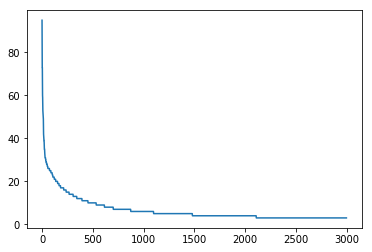

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# Count how many different words are found in tweets
word_count_list = []
for key, value in word_count.items():
    word_count_list.append(value)
print('Total number of words found:', len(word_count_list))

# Plot the distribution of words
plt.plot(sorted(word_count_list, reverse=True)[2:vocabulary_size])

# Find whow many words are found N times or more
word_threshold = 4
word_count_list = [word_count for word_count in word_count_list if word_count >= word_threshold]

print('Number of words found', str(word_threshold), 'times or more:', len(word_count_list))

## Codification of tokens

Turn tweets into an array of numbers where each number is a word in the vocabulary. Also, the algorithm needs all tweets to be the same length, so we need to choose a tweet length and pad those that are shorter with "NOWORD".

In [9]:
def convert_and_pad(word_dict, sentence, pad=15):
    NOWORD = 0 # We will use 0 to represent the 'no word' category
    INFREQ = 1 # and we use 1 to represent the infrequent words, i.e., words not appearing in word_dict
    
    working_sentence = [NOWORD] * pad
    
    for word_index, word in enumerate(sentence[:pad]):
        if word in word_dict:
            working_sentence[word_index] = word_dict[word]
        else:
            working_sentence[word_index] = INFREQ
            
    return working_sentence, min(len(sentence), pad)

def convert_and_pad_data(word_dict, data, pad=15):
    result = []
    lengths = []
    
    for sentence in data:
        converted, leng = convert_and_pad(word_dict, sentence, pad)
        result.append(converted)
        lengths.append(leng)
        
    return np.array(result), np.array(lengths)

### Choose the right length

In order to save some RAM, I am not looking to cover the length of the longest tweet, but the vast majority.

In [10]:
lengths = []
for sentence in train_df['words']:
    lengths.append(len(sentence))
    
percentile = 99.9
padded_length = int(np.percentile(lengths, percentile))
print('To cover', percentile, '% of tweets the right length is:', padded_length)
print('The longest tweet is', len(max(train_df['words'], key=len)), 'words long')

To cover 99.9 % of tweets the right length is: 25
The longest tweet is 31 words long


### Codification

In [11]:
train_x, train_x_len = convert_and_pad_data(word_vocabulary, train_df['words'], pad=padded_length)
test_x, test_x_len = convert_and_pad_data(word_vocabulary, test_df['words'], pad=padded_length)

Check that conversion went well.

In [12]:
idx = np.random.randint(len(train_df))
print('Index generated randomly:', idx)
print('Original text:', train_df.iloc[idx]['text'])
print('Tokenized:', train_df.iloc[idx]['words'])
print('Codified:', train_x[idx])

Index generated randomly: 7137
Original text: #USGS M 1.9 - 5km S of Volcano Hawaii: Time2015-08-06 01:04:01 UTC2015-08-05 15:04:01 -10:00 at epicenter... http://t.co/dIsrwhQGym #SM
Tokenized: ['usg isnumb', 'isnumb isnumb', 'isnumb km', 'km volcano', 'volcano hawaii', 'hawaii time', 'time isnumb', 'isnumb isnumb', 'isnumb isnumb', 'isnumb isnumb', 'isnumb isnumb', 'isnumb isnumb', 'isnumb utc', 'utc isnumb', 'isnumb isnumb', 'isnumb isnumb', 'isnumb isnumb', 'isnumb isnumb', 'isnumb isnumb', 'isnumb isnumb', 'isnumb isnumb', 'isnumb epicent', 'epicent isnumb', 'islink', 'isnumb sm']
Codified: [1849    3   42  508  509 2100   25    3    3    3    3    3   96  197
    3    3    3    3    3    3    3    1    1    2 2842]


## Save data to train the model

### Save vocabulary

In [13]:
import os
import pickle

data_dir = 'data' # The folder we will use for storing data
if not os.path.exists(data_dir): # Make sure that the folder exists
    os.makedirs(data_dir)

with open(os.path.join(data_dir, 'word_vocab.pkl'), "wb") as f:
    pickle.dump(word_vocabulary, f)

### Save training dataset

Save the post-processed training dataset

In [14]:
pd.concat([pd.DataFrame(train_labels), pd.DataFrame(train_x_len), pd.DataFrame(train_x)], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

### Upload data so S3

In [15]:
# Upload data to S3
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/cp01'

role = sagemaker.get_execution_role()

input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

## Training the model

In [16]:
# Training the model

from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train.py",
                    source_dir="train",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.m4.xlarge',
                    hyperparameters={
                        'epochs': 10,
                        'hidden_dim': 200,
                        'vocab_size': vocabulary_size
                    })

In [17]:
estimator.fit({'training': input_data})

2020-01-20 15:47:52 Starting - Starting the training job...
2020-01-20 15:47:54 Starting - Launching requested ML instances...
2020-01-20 15:48:51 Starting - Preparing the instances for training......
2020-01-20 15:49:45 Downloading - Downloading input data...
2020-01-20 15:50:12 Training - Downloading the training image.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-01-20 15:50:24,867 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-01-20 15:50:24,870 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-01-20 15:50:24,883 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-01-20 15:50:24,886 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-01-20 15:50:25,120 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-01-20 15:50:25,121 

## Deployment

In [18]:
# Deploy estimator

# Remember to shut down the endpoint when we are done!!!!

predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

--------------------------------------------------------------------------!

## Testing

### Prepare test data

In [19]:
test_X = pd.concat([pd.DataFrame(test_x_len), pd.DataFrame(test_x)], axis=1)

### Predict

In [20]:
# We split the data into chunks and send each chunk seperately, accumulating the results.
def predict(data, rows=512):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = np.array([])
    for array in split_array:
        predictions = np.append(predictions, predictor.predict(array))
    
    return predictions

In [21]:
predictions = predict(test_X.values)
rounded_predictions = [round(num) for num in predictions]

### Save predictions for submission to Kaggle

Kaggle expects a 2-column CSV file. First column containing the _id_ and the second one our predicted _target_.

In [22]:
# Prepara dataframe
predictions_df = pd.DataFrame(rounded_predictions, index=test_df.index, columns=['target']).astype('int64')
predictions_df.head()

,target
id,
0,0
2,1
3,0
9,0
11,0


In [23]:
# Save to a .csv file
predictions_df.to_csv(r'data/predictions.csv', header=True)

A file with predictions has been saved in "data/predictions.csv". Now we can upload it to Kaggle manually and find out how it performed.